In [1]:
google_colab = False

# Google Colab用事前準備

In [2]:
# install
if google_colab:
  !pip install pybind11
  %cd /content
  !nvcc -V
  !sudo rm -fr BinaryBrain
  !rm -fr BinaryBrain
  !git clone --recursive -b ver3_develop https://github.com/ryuz/BinaryBrain.git
  %cd /content/BinaryBrain/python
  !sh copy_src.sh
  !python3 setup.py build
  !python3 setup.py develop

  import binarybrain as bb

In [3]:
import binarybrain as bb
import importlib
importlib.reload(bb)
importlib

<module 'importlib' from 'c:\\users\\ryuji\\appdata\\local\\programs\\python\\python37\\lib\\importlib\\__init__.py'>

In [4]:
# mount
if google_colab:
  from google.colab import drive 
  drive.mount('/content/drive')
  %cd /content/drive/My Drive/git-work/BinaryBrain_ver3_develop/tests/python

In [5]:
import binarybrain as bb
prop = bb.get_device_properties(0)
print(prop)


name                     : GeForce GTX 1660 SUPER
totalGlobalMem           : 6442450944
sharedMemPerBlock        : 49152
regsPerBlock             : 65536
warpSize                 : 32
memPitch                 : 2147483647
maxThreadsPerBlock       : 1024
maxThreadsDim[0]         : 1024
maxThreadsDim[1]         : 1024
maxThreadsDim[2]         : 64
maxGridSize[0]           : 2147483647
maxGridSize[1]           : 65535
maxGridSize[2]           : 65535
clockRate                : 1800000
totalConstMem            : 65536
major                    : 7
minor                    : 5
textureAlignment         : 512
deviceOverlap            : 1
multiProcessorCount      : 22
kernelExecTimeoutEnabled : 1
integrated               : 0
canMapHostMemory         : 1
computeMode              : 0




# メインコード

In [6]:
import binarybrain as bb
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
import sys
from tqdm import tqdm
from collections import OrderedDict

In [7]:
# load MNIST data
src_td = bb.load_mnist()

In [8]:
def image_transform(img):
    angle = random.uniform(-10.0, +10.0)
    scale = random.uniform(0.8, 1.1)
    trans = cv2.getRotationMatrix2D((14, 14), angle , scale)
    trans[0][2] += random.uniform(-2.0, 2.0)
    trans[1][2] += random.uniform(-2.0, 2.0)
    return cv2.warpAffine(img.reshape(28, 28), trans, (28, 28))

def make_td_image(src_x, src_t, w=28, h=28, depth=27):
    l = len(src_x)
    mx = (28 + depth + w + depth + 27) // 28
    my = (28 + depth + h + depth + 27) // 28
    dst_x = np.zeros(( 1, 28*my, 28*mx), dtype=np.float32)
    dst_t = np.zeros((10, 28*my, 28*mx), dtype=np.float32)
    for y in range(my):
        for x in range(mx):
            i = random.randrange(0, l)
            dst_x[0,y*28:y*28+28, x*28:x*28+28] = image_transform(src_x[i])
            dst_t[:,y*28:y*28+28, x*28:x*28+28] = np.tile(src_t[i], (28,28)).reshape(28, 28, 10).transpose(2, 0, 1)
    x_flag0 = dst_x[0] <= 0.5
    x_flag1 = dst_x[0] >  0.5
    for i in range(10):
        dst_t[i][x_flag0] = 0
    
    xs = random.randrange(0, 28)
    ys = random.randrange(0, 28)
    dst_x  = dst_x[:,ys:ys+2*depth+h,xs:xs+2*depth+w]
    x_flag = x_flag1[ys:ys+2*depth+h,xs:xs+2*depth+w]
    
    dst_t  = dst_t[:,ys+depth:ys+depth+h,xs+depth:xs+depth+w]
    t_flag = x_flag1[ys+depth:ys+depth+h,xs+depth:xs+depth+w]
    
    x_mask = np.zeros(x_flag.shape, dtype=np.float32)
    x_mask[x_flag] = 1.0
    t_mask = np.zeros(t_flag.shape, dtype=np.float32)
    t_mask[t_flag] = 1.0
    return dst_x.flatten(), dst_t.flatten(), x_mask.flatten(), t_mask.flatten()

def generate_td(src_td, train_size=60000//4, test_size=10000//4, w=28, h=28, depth=27):
    dst_td = {}
    
    dst_td['x_train']      = []
    dst_td['t_train']      = []
    dst_td['x_mask_train'] = []
    dst_td['t_mask_train'] = []
    for _ in tqdm(range(train_size)):
        x, t, xm, tm = make_td_image(src_td['x_train'], src_td['t_train'], w=w, h=h, depth=depth)
        dst_td['x_train'].append(x)
        dst_td['t_train'].append(t)
        dst_td['x_mask_train'].append(xm)
        dst_td['t_mask_train'].append(tm)
    dst_td['x_train']      = np.array(dst_td['x_train'])
    dst_td['t_train']      = np.array(dst_td['t_train'])
    dst_td['x_mask_train'] = np.array(dst_td['x_mask_train'])
    dst_td['t_mask_train'] = np.array(dst_td['t_mask_train'])
    
    dst_td['x_test']      = []
    dst_td['t_test']      = []
    dst_td['x_mask_test'] = []
    dst_td['t_mask_test'] = []
    for _ in tqdm(range(test_size)):
        x, t, xm, tm = make_td_image(src_td['x_test'], src_td['t_test'], w=w, h=h, depth=depth)
        dst_td['x_test'].append(x)
        dst_td['t_test'].append(t)
        dst_td['x_mask_test'].append(xm)
        dst_td['t_mask_test'].append(tm)
    dst_td['x_test']      = np.array(dst_td['x_test'])
    dst_td['t_test']      = np.array(dst_td['t_test'])
    dst_td['x_mask_test'] = np.array(dst_td['x_mask_test'])
    dst_td['t_mask_test'] = np.array(dst_td['t_mask_test'])
    
    dst_td['x_shape'] = [depth*2+w, depth*2+h, 1]
    dst_td['t_shape'] = [w, h, 10]
    
    return dst_td

In [9]:
# 設定
layer_depth = 27
t_width     = 28*2
t_height    = 28*2

In [10]:
td = generate_td(src_td, w=t_width, h=t_height, depth=layer_depth)

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:04<00:00, 526.10it/s]


In [11]:
color_table = [
    [0xe6, 0x00, 0x12],  # 0
    [0x92, 0x07, 0x83],  # 1
    [0x1d, 0x20, 0x88],  # 2
    [0x00, 0x68, 0xb7],  # 3
    [0x00, 0xa0, 0xe9],  # 4
    [0x00, 0x9e, 0x96],  # 5
    [0x00, 0x99, 0x44],  # 6
    [0x8f, 0xc3, 0x1f],  # 7
    [0xff, 0xf1, 0x00],  # 8
    [0xf3, 0x98, 0x00],  # 9
    [0x00, 0x00, 0x00],  # BGC
]

def frame_to_image(frame, mask):
    idx_img = np.argmax(frame, axis=0)
    rgb_img = np.ndarray((idx_img.shape[0], idx_img.shape[1], 3), dtype=np.uint8)
    for y in range(idx_img.shape[1]):
        for x in range(idx_img.shape[0]):
            rgb_img[y][x] = np.array(color_table[idx_img[y][x]]) * mask[y][x]
    return rgb_img

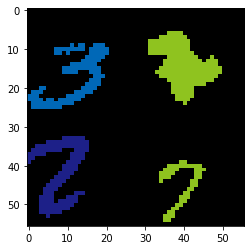

In [12]:
i = 9
plt.imshow(frame_to_image(td['t_train'][i].reshape(10, 28*2, 28*2), td['t_mask_train'][i].reshape(28*2, 28*2)))

## ネット定義

In [13]:
def make_cnv(ch_size, w=3, h=3):
    subnet = bb.Sequential.create()
    subnet.add(bb.DenseAffine.create([ch_size]))
    subnet.add(bb.BatchNormalization.create())
    subnet.add(bb.BinarizeBit.create())
    return bb.LoweringConvolutionBit.create(subnet, w, h)

In [14]:
# build network
modulation_size = 1
layer_rel2bin = bb.RealToBinaryBit.create(modulation_size, framewise=True)
layer_bin2rel = bb.BinaryToRealBit.create(modulation_size)

main_net = bb.Sequential.create()
main_net.add(layer_rel2bin)
for _ in range(layer_depth):
    main_net.add(make_cnv(32, 3, 3))
main_net.add(make_cnv(10, 1, 1))
main_net.add(layer_bin2rel)

main_net.set_input_shape(td['x_shape'])
main_net.send_command('binary true')

print(main_net.get_info())

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -----------------------

In [16]:
loss      = bb.LossSoftmaxCrossEntropy.create()
metrics   = bb.MetricsCategoricalAccuracy.create()
optimizer = bb.OptimizerAdam.create()
optimizer.set_variables(main_net.get_parameters(), main_net.get_gradients())

runner = bb.Runner(main_net, "mnist-dense-cnn-binary", loss, metrics, optimizer)
runner.fitting(td, epoch_size=1, mini_batch_size=32, file_write=True, file_read=False)

epoch=1 test_accuracy=0.880579 test_loss=580.483415 train_accuracy=0.876927 train_loss=576.559797


In [29]:
def plot_image(net, td):
    x_buf = bb.FrameBuffer()
    x_buf.resize(16, td['x_shape'])
    x_buf.set_data(td['x_test'][0:16])
    y_buf = net.forward(x_buf, False)

    data = y_buf.get_data(0)

    frame = np.array(data[0]).reshape(56, 56, -1)
    print(frame.shape)
    plt.imshow(frame_to_image(frame.reshape(10, 56, 56), td['t_mask_test'][0].reshape(56, 56)))
    plt.show()

(56, 56, 10)


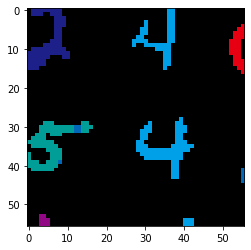

In [30]:
plot_image(main_net, td)

In [28]:
td['x_mask_test'][0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)